# Detecção de Fake news em português

In [ ]:
# !pip install unidecode
# !pip install spacy
# !pip install emoji
# !pip install gensim
# !pip install wordcloud
# !pip install scikit-plot
# !python -m spacy download pt_core_news_sm


In [1]:
import nltk 
from nltk import tokenize
import re
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('rslp')
from nltk.stem.snowball import SnowballStemmer
import pandas as pd
import numpy as np
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from gensim.models import Phrases
import spacy
import unidecode
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.stem import RSLPStemmer
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from yellowbrick.classifier import ROCAUC
import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/lauradamacenodealmeida/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/lauradamacenodealmeida/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package rslp to
[nltk_data]     /Users/lauradamacenodealmeida/nltk_data...
[nltk_data]   Package rslp is already up-to-date!
/Users/lauradamacenodealmeida/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
# df = pd.read_excel('/Users/lauradamacenodealmeida/Downloads/Dataset_FakeNewsV1 (3).xlsx')
df_validacao = pd.read_excel('/Users/lauradamacenodealmeida/Downloads/Dataset Validação (1).xlsx')
df = pd.read_excel('/Users/lauradamacenodealmeida/Downloads/data_set.xlsx')


In [3]:
df.shape

(7200, 29)

In [4]:
df.tail()

,Unnamed: 0,FILE_NAME,CLASS,TEXT,AUTHOR,LINK,CATEGORY,DATE_OF_PUBLICATION,NUMBER_OF_TOKENS,NUMBER_OF_WORDS_WITHOUT_PUNCTUATION,...,NUMBER_OF_SINGULAR_FIRST_AND_SECOND_PERSONAL_PRONOUNS,NUMBER_OF_PLURAL_FIRST_PERSONAL_PRONOUNS,NUMBER_OF_PRONOUNS,PAUSALITY,NUMBER_OF_CHARACTERS,AVERAGE_SENTENCE_LENGTH,AVERAGE_WORD_LENGTH,PERCENTAGE_OF_NEWS_WITH_SPEELING_ERRORS,EMOTIVENESS,DIVERSITY
7195,7195,995.txt,1,"Para jornal britânico, ação contra Lula na Lav...","Célia Froufe, correspondente, O Estado de S.P...","http://politica.estadao.com.br/noticias/geral,...",politica,22 de novembro de 2016,637,567,...,0,0,27,3.50000,2708,28.3500,4.77601,0.001764,0.141176,0.513228
7196,7196,996.txt,1,Temer diz que acionou PF e Cade para investiga...,"Por G1, Brasília",https://g1.globo.com/politica/noticia/temer-di...,politica,09/02/2018 08h25,1115,949,...,7,2,43,3.01818,4520,17.2545,4.76291,0.002107,0.228710,0.420443
7197,7197,997.txt,1,Os obstáculos políticos de Temer em 2017. Espe...,"Por Luciana Amaral, G1, Brasília",https://g1.globo.com/politica/noticia/os-obsta...,politica,31/12/2016 05h00,1698,1463,...,0,0,65,3.50746,7142,21.8358,4.88175,0.000000,0.245955,0.414901
7198,7198,998.txt,1,"Sexta-feira, 15 de setembro de 2017. Boa noite...",Por G1,https://g1.globo.com/resumo-do-dia/noticia/sex...,sociedade_cotidiano,15/09/2017 20h46,742,648,...,1,2,31,2.76471,3003,19.0588,4.63426,0.001543,0.184300,0.614198
7199,7199,999.txt,1,"'Não me envolvo em política', diz brasileiro q...",Por G1 SC,https://g1.globo.com/sc/santa-catarina/noticia...,tv_celebridades,08/01/2018 11h58,2246,2006,...,36,4,234,3.24324,9167,27.1081,4.56979,0.004985,0.297430,0.373380


In [4]:
df = df[df['CATEGORY']=='politica']

In [6]:
# df[df.index == 141]

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4180 entries, 0 to 7197
Data columns (total 29 columns):
 #   Column                                                 Non-Null Count  Dtype  
---  ------                                                 --------------  -----  
 0   Unnamed: 0                                             4180 non-null   int64  
 1   FILE_NAME                                              4180 non-null   object 
 2   CLASS                                                  4180 non-null   int64  
 3   TEXT                                                   4180 non-null   object 
 4   AUTHOR                                                 4180 non-null   object 
 5   LINK                                                   4180 non-null   object 
 6   CATEGORY                                               4180 non-null   object 
 7   DATE_OF_PUBLICATION                                    4180 non-null   object 
 8   NUMBER_OF_TOKENS                                

In [7]:
df_validacao.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 761 entries, 0 to 760
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Matéria   761 non-null    object
 1   Título    761 non-null    object
 2   Conteúdo  761 non-null    object
 3   Fake      761 non-null    int64 
dtypes: int64(1), object(3)
memory usage: 23.9+ KB


In [13]:
# df.drop(columns=['Unnamed: 4'], inplace=True)
# df.drop(columns=['Unnamed: 0'], inplace=True)

In [9]:
# df.dropna(inplace=True)

## Pré processamento dos dados

In [5]:
df.shape

(4180, 29)

In [6]:
# df['quantidade_palavras'] = df['Conteúdo'].str.split().apply(len)
df['quantidade_palavras'] = df['TEXT'].str.split().apply(len)


In [7]:
df_validacao['quantidade_palavras'] = df_validacao['Conteúdo'].str.split().apply(len)


In [8]:
df.tail()

,Unnamed: 0,FILE_NAME,CLASS,TEXT,AUTHOR,LINK,CATEGORY,DATE_OF_PUBLICATION,NUMBER_OF_TOKENS,NUMBER_OF_WORDS_WITHOUT_PUNCTUATION,...,NUMBER_OF_PLURAL_FIRST_PERSONAL_PRONOUNS,NUMBER_OF_PRONOUNS,PAUSALITY,NUMBER_OF_CHARACTERS,AVERAGE_SENTENCE_LENGTH,AVERAGE_WORD_LENGTH,PERCENTAGE_OF_NEWS_WITH_SPEELING_ERRORS,EMOTIVENESS,DIVERSITY,quantidade_palavras
7189,7189,99.txt,1,Caminhada da paz em RR promove debates sobre r...,G1 RR,https://g1.globo.com/rr/roraima/noticia/caminh...,politica,1/1/2018,287,251,...,0,5,4.00000,1232,27.8889,4.90837,0.000000,0.149123,0.605578,246
7192,7192,992.txt,1,Senado aprova em 1o turno fim do foro privileg...,"Por Gustavo Garcia, G1, Brasília",https://g1.globo.com/politica/noticia/senado-a...,politica,26/04/2017 19h06,666,575,...,0,22,3.37037,2900,21.2963,5.04348,0.000000,0.183824,0.453913,571
7195,7195,995.txt,1,"Para jornal britânico, ação contra Lula na Lav...","Célia Froufe, correspondente, O Estado de S.P...","http://politica.estadao.com.br/noticias/geral,...",politica,22 de novembro de 2016,637,567,...,0,27,3.50000,2708,28.3500,4.77601,0.001764,0.141176,0.513228,562
7196,7196,996.txt,1,Temer diz que acionou PF e Cade para investiga...,"Por G1, Brasília",https://g1.globo.com/politica/noticia/temer-di...,politica,09/02/2018 08h25,1115,949,...,2,43,3.01818,4520,17.2545,4.76291,0.002107,0.228710,0.420443,949
7197,7197,997.txt,1,Os obstáculos políticos de Temer em 2017. Espe...,"Por Luciana Amaral, G1, Brasília",https://g1.globo.com/politica/noticia/os-obsta...,politica,31/12/2016 05h00,1698,1463,...,0,65,3.50746,7142,21.8358,4.88175,0.000000,0.245955,0.414901,1455


In [9]:
token_pontuacao = tokenize.WordPunctTokenizer()


In [10]:
from string import punctuation
pontuacao = list()
for ponto in punctuation:
    pontuacao.append(ponto)

In [11]:
frase_processada = list()
def tokenize_frase(frase):
    stemmer = RSLPStemmer()
    palavras_texto = frase.lower()
    palavras_texto = token_pontuacao.tokenize(frase)
    palavra = []
    stopwords = nltk.corpus.stopwords.words('portuguese')
    for i in palavras_texto:
        if not i.isnumeric() and i.lower() not in stopwords and i not in pontuacao:
            palavra.append(stemmer.stem(i.lower()))

    #     frase = nltk.word_tokenize(frase)
    frase_processada.append(' '.join(palavra))
    #return palavra

In [12]:
def removerAcentosECaracteresEspeciais(frase):
    
    frase_sem_acento = unidecode.unidecode(frase)
    # Usa expressão regular para retornar a palavra apenas com números, letras e espaço
    return re.sub('[^a-zA-Z \\\]', '', frase_sem_acento)

In [13]:
nlp = spacy.load('pt_core_news_sm')

def lematizar(texto_original):
    palavras_importantes = remover_stopwords(texto_original, lista=True)
    
    texto_importante = ' '.join(palavras_importantes)
    texto_importante = remover_underscore(remover_acento(texto_importante))
    
    doc = nlp(texto_importante)
    doc_lematizado = [token.lemma_ if token.pos_ == 'VERB' else str(token) for token in doc]
    return ' '.join(doc_lematizado)

In [14]:
def preprocess(data):
    data  = removerAcentosECaracteresEspeciais(data)
    tokenize_frase(data)
    

In [15]:
# df.loc[~df["Conteúdo"].isnull()]["Conteúdo"].map(preprocess) 
df.loc[~df["TEXT"].isnull()]["TEXT"].map(preprocess) 

0       None
1       None
2       None
3       None
4       None
        ... 
7189    None
7192    None
7195    None
7196    None
7197    None
Name: TEXT, Length: 4180, dtype: object

In [16]:
df['tratamento_1'] = frase_processada

In [17]:
frase_processada = list()

In [18]:
df_validacao.loc[~df_validacao["Conteúdo"].isnull()]["Conteúdo"].map(preprocess) 
df_validacao['tratamento_1'] = frase_processada

In [19]:
df_validacao.head()

,Matéria,Título,Conteúdo,Fake,quantidade_palavras,tratamento_1
0,https://contraponto.jor.br/acuado-bolsonaro-ch...,"Acuado, Bolsonaro chama para coletiva de impre...",Acuado pelos protestos que se repetiram em vár...,0,71,acu protest repet var capit noit tercaf presid...
1,https://contraponto.jor.br/general-augusto-hel...,General Augusto Heleno testa positivo para Cor...,"O general Augusto Heleno, ministro-chefe do Ga...",0,94,gener august helen ministrochef gabinet segura...
2,https://contraponto.jor.br/bolsonaro-e-alvo-de...,Bolsonaro é alvo de panelaços em todo o país,Panelaços contra o presidente Jair Bolsonaro f...,0,259,panelac contr presid jair bolsonar ouv dur noi...
3,https://contraponto.jor.br/psdb-de-curitiba-an...,PSDB de Curitiba anuncia desfiliação de Eduard...,O presidente do diretório municipal de Curitib...,0,172,presid diretori municip curitib psdb edson lau...
4,https://contraponto.jor.br/novo-decreto-suspen...,Novo decreto suspende aulas em escolas particu...,As aulas nas escolas particulares do Paraná ta...,0,250,aul escol particul paran tamb sera suspens par...


In [23]:
df.loc[4]['tratamento_1']

'radial americ fal sobr pt vend ilusa pov brasil so pens divert siti radial americ alex jon chor fal crianc saud brasil jon cit microcefal espalh mund part descas cris poli brasil esquerd nao faz nad so vend iluso sei dev chamal diss jon fim vide radial fal sobr surt microcefal nao contev caiu lagr crianc nao ampar precis pesso boa ajud pesso deix microcefal cresc ness pal'

## Visualização de palavras mais frequentes em cada tipo de notícia

In [24]:
def wordcloud_news(texto, coluna_texto, coluna_fake, fake):
    todas_palavras = ' '.join([texto for texto in texto[texto[coluna_fake]== fake][coluna_texto]]) #lista contendo todas as frases

    word_cloud = WordCloud(width=800, height=500,max_font_size=110).generate(todas_palavras)
    plt.figure(figsize=[10,10])
    plt.imshow(word_cloud, interpolation="bilinear")
    #plt.title('Palavras mais comuns em notícias fake')

    plt.axis("off")
    plt.show()

In [25]:
def pareto(texto, coluna, coluna_fake, fake,quantidade):
    todas_palavras = ' '.join([texto for texto in texto[texto[coluna_fake]== fake][coluna]]) #lista contendo todas as frases

#     todas_palavras = ' '.join([text for text in texto[texto[coluna_fake]== fake]][coluna]) #lista contendo todas as frases
    token_espaco = tokenize.WhitespaceTokenizer()
    token = token_espaco.tokenize(todas_palavras)
    frequencia = nltk.FreqDist(token)
    df_frequencia = pd.DataFrame({'Palavra': list(frequencia.keys()), 'Frequencia': list(frequencia.values())})
    df_frequencia = df_frequencia.nlargest(columns= "Frequencia", n=quantidade)
    
    plt.figure(figsize=(12,8))
    ax = sns.barplot(data = df_frequencia, x = "Palavra", y = "Frequencia")
    ax.set(ylabel="Contagem")
    plt.show()
    


In [26]:
# df[df['Fake']==0]['quantidade_palavras'].describe()
df[df['CLASS']==0]['quantidade_palavras'].describe()

count    2090.000000
mean      185.104306
std       132.081280
min        10.000000
25%       118.000000
50%       156.000000
75%       218.000000
max      2288.000000
Name: quantidade_palavras, dtype: float64

Temos mais de 75% das noticias fake news tem quantidade de palavras menor que 218 caracteres. Portanto notícias fakes tendem a ser muito pequenas comparadas com as não fake.

Entretanto temos um possivel outlier, pois tem uma noticia com mais de 2288 palavras

In [28]:
# df[df['Fake']==1]['quantidade_palavras'].describe()
df[df['CLASS']==1]['quantidade_palavras'].describe()

count    2090.000000
mean     1050.886124
std       623.787900
min       103.000000
25%       623.000000
50%       885.500000
75%      1369.500000
max      5373.000000
Name: quantidade_palavras, dtype: float64

Temos mais de 75% das noticias não fake news tem quantidade de palavras menor que 1369 caracteres.


In [29]:
# print('A média da quantidade de palavras em noticias fake é {}'.format(df[df['Fake']==0]['quantidade_palavras'].mean()))

print('A média da quantidade de palavras em noticias fake é {}'.format(df[df['CLASS']==0]['quantidade_palavras'].mean()))


A média da quantidade de palavras em noticias fake é 185.10430622009568


In [30]:
# print('A média da quantidade de palavras em noticias não fake é {}'.format(df[df['Fake']==1]['quantidade_palavras'].mean()))
print('A média da quantidade de palavras em noticias não fake é {}'.format(df[df['CLASS']==1]['quantidade_palavras'].mean()))




A média da quantidade de palavras em noticias não fake é 1050.8861244019138


A média de quantidade de palavras é maior em noticias não fake

Text(0.5, 1.0, 'Distribuição de noticias fakes e não fakes')

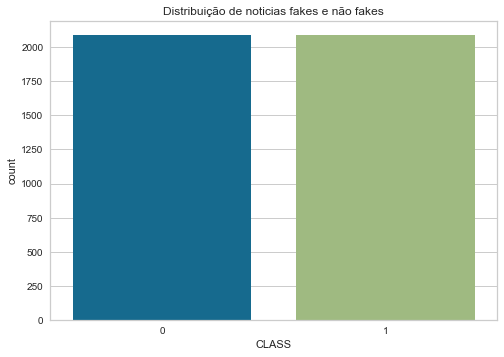

In [31]:
# sns.countplot(df.Fake)
sns.countplot(df.CLASS)

plt.title('Distribuição de noticias fakes e não fakes')

In [24]:
# df.Fake.value_counts()
df.CLASS.value_counts()
# df_validacao.Fake.value_counts()

1    2090
0    2090
Name: CLASS, dtype: int64

Nossas classes estão desbalanceadas, então provavelmente a acurácia pode não ser a melhor métrica.

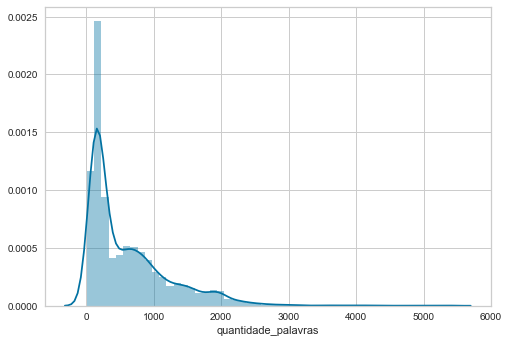

In [33]:
sns.distplot(df.quantidade_palavras)

Text(0.5, 1.0, 'Distribuição da quantidade de palavras em noticias fakes')

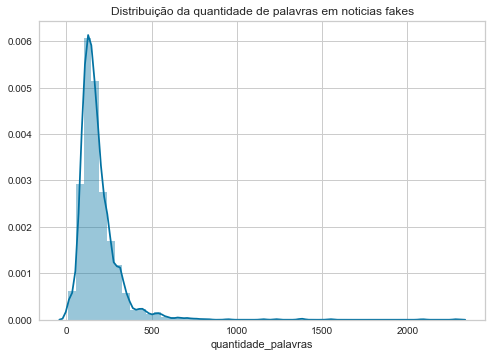

In [34]:
# sns.distplot(df[df['Fake']==0].quantidade_palavras)
sns.distplot(df[df['CLASS']==0].quantidade_palavras)

plt.title('Distribuição da quantidade de palavras em noticias fakes')

Text(0.5, 1.0, 'Distribuição da quantidade de palavras em noticias não fakes')

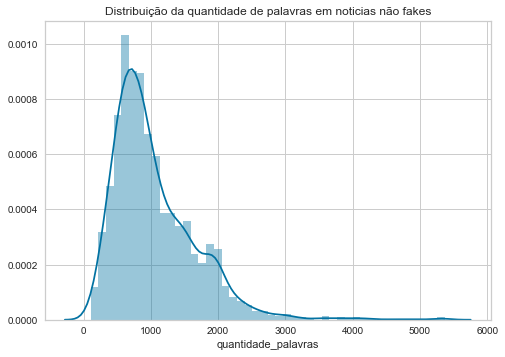

In [35]:
# sns.distplot(df[df['Fake']==1].quantidade_palavras)
sns.distplot(df[df['CLASS']==1].quantidade_palavras)

plt.title('Distribuição da quantidade de palavras em noticias não fakes')

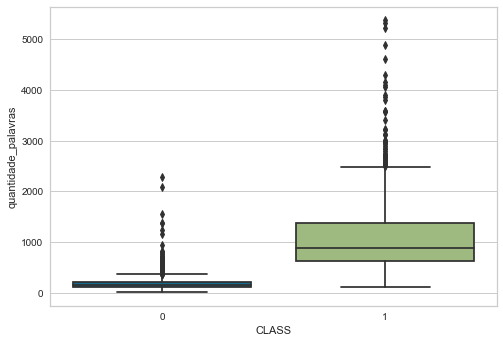

In [36]:
# ax = sns.boxplot(x="Fake", y="quantidade_palavras", data=df)
ax = sns.boxplot(x="CLASS", y="quantidade_palavras", data=df)

ax

#### Wordcloud de fake news

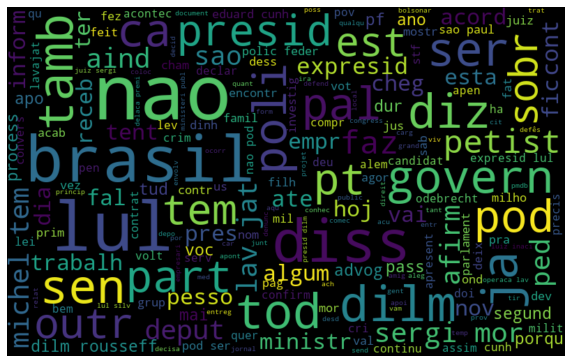

In [41]:

# wordcloud_news(df,'tratamento_1','Fake',0)   
wordcloud_news(df,'tratamento_1','CLASS',0)    

#### Visualização em pareto de fake news

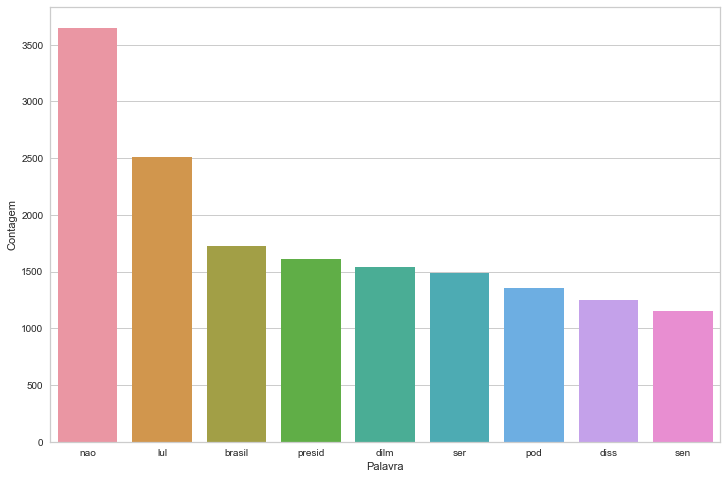

In [42]:
# pareto(df,'tratamento_1','Fake',0, 9)
pareto(df,'tratamento_1','CLASS',0, 9)

#### Wordcloud de noticias não fake

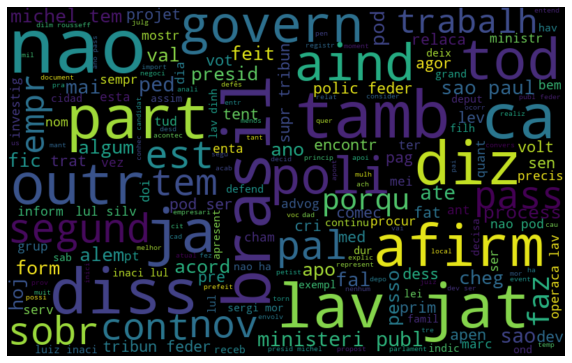

In [39]:
# wordcloud_news(df,'tratamento_1','Fake',1)    
wordcloud_news(df,'tratamento_1','CLASS',1)    


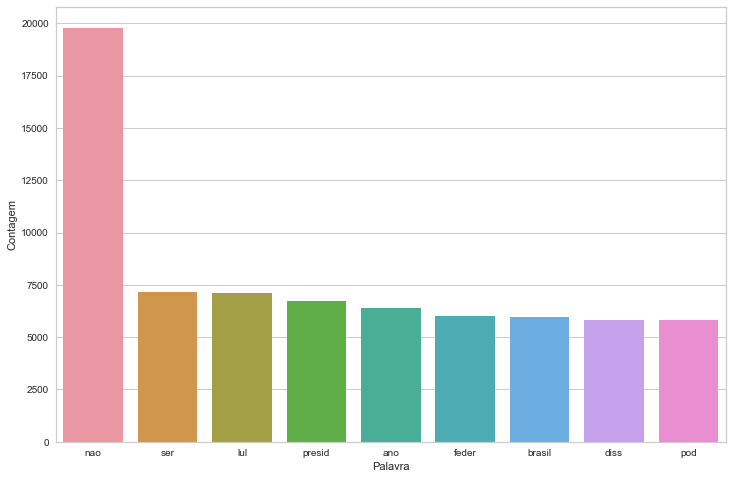

In [40]:
# pareto(df,'tratamento_1','Fake',1, 9)
pareto(df,'tratamento_1','CLASS',1, 9)

## Validação Cruzada

A validação cruzada é um método de reamostragem e tem como objetivo avaliar a capacidade de generalização do seu modelo. 
Em outras palavras, verificar o quão pronto seu modelo está para receber novos dados.



In [20]:
def avalia_modelo(modelo, x, y):
    return cross_validate(modelo, x, y, return_train_score=False,
               scoring=['accuracy',
                        'f1',
                        'precision',
                        'recall',
                        'roc_auc'])

## Métricas

In [21]:
def metrica_geral(teste, predict):
    metrica = metrics.classification_report(teste,predict)
    print(metrica)

In [22]:
def f1_score(teste, predict):
    f1 = metrics.f1_score(test_Y, predict,pos_label = 1)
    return f1

In [23]:
def matriz_confusao(teste, predict):
    fig, ax = plt.subplots()
    matriz = metrics.confusion_matrix(teste,predict)
#     classes = df['Fake'].unique()
    classes = df['CLASS'].unique()

    im = ax.imshow(matriz,cmap=plt.cm.Blues)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(matriz.shape[1]),
           yticks=np.arange(matriz.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title='Matriz de confusão',
           ylabel='True label',
           xlabel='Predicted label')
    thresh = matriz.max().mean()
    for i in range(matriz.shape[0]):
        for j in range(matriz.shape[1]):
            ax.text(j, i, format(matriz[i, j]),
                ha="center", va="center",
                color="white" if matriz[i, j] > thresh else "black")
    fig.tight_layout()

In [24]:

def curva_ROC(model,X_test,y_true):
    fig,aux = plt.subplots(figsize=(6,6))
    roc_viz = ROCAUC(model)
    roc_viz.score(X_test,y_true)
    roc_viz.poof()
    #return roc_auc_score(teste, predict)

## Pipeline SVM

### SVM Linear

In [25]:
df2 = df

In [26]:
svm = SVC(C=1.0, kernel='linear', degree=3, gamma='auto',probability=True)
svm_bigram = SVC(C=1.0, kernel='linear', degree=3, gamma='auto',probability=True)
svm_bag = SVC(C=1.0, kernel='linear', degree=3, gamma='auto',probability=True)
svm_bag_bigram = SVC(C=1.0, kernel='linear', degree=3, gamma='auto',probability=True)



In [27]:

pip_SVM_bag = Pipeline([('text_processing',CountVectorizer()),('SVM',svm_bag)])
pip_SVM_bagbi = Pipeline([('text_processing',CountVectorizer(ngram_range=(1, 2))),('SVM',svm_bag_bigram)])
pip_SVM_tfidf = Pipeline([('text_processing',TfidfVectorizer()),('SVM',svm)])
pip_SVM_tfidf_bi = Pipeline([('text_processing',TfidfVectorizer(ngram_range=(1, 2))),('SVM',svm_bigram)])



In [50]:
pip_SVM_bag.steps

[('text_processing',
  CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                  dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                  lowercase=True, max_df=1.0, max_features=None, min_df=1,
                  ngram_range=(1, 1), preprocessor=None, stop_words=None,
                  strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                  tokenizer=None, vocabulary=None)),
 ('SVM',
  SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
      decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
      max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
      verbose=False))]

In [53]:
avalia_modelo(pip_SVM_bag, df2['tratamento_1'], df2.CLASS)

{'fit_time': array([22.79992795, 20.11472392, 19.47911501, 18.88443804, 17.25067806]),
 'score_time': array([1.98370695, 1.97090721, 1.98727393, 2.04500389, 1.97924709]),
 'test_accuracy': array([0.94976077, 0.95933014, 0.97009569, 0.97607656, 0.95095694]),
 'test_f1': array([0.94902913, 0.95823096, 0.96940024, 0.97601918, 0.95078031]),
 'test_precision': array([0.96305419, 0.98484848, 0.9924812 , 0.97836538, 0.95421687]),
 'test_recall': array([0.9354067 , 0.93301435, 0.94736842, 0.97368421, 0.94736842]),
 'test_roc_auc': array([0.98882809, 0.994746  , 0.99293743, 0.9943282 , 0.98719695])}

In [54]:
avalia_modelo(pip_SVM_bagbi, df2['tratamento_1'], df2.CLASS)

{'fit_time': array([45.67440701, 50.13278413, 47.69982719, 46.51225114, 41.67604899]),
 'score_time': array([4.47807002, 4.76124716, 4.64424801, 4.73306799, 4.64439106]),
 'test_accuracy': array([0.95933014, 0.96052632, 0.96770335, 0.97727273, 0.95215311]),
 'test_f1': array([0.95903614, 0.95930949, 0.96678967, 0.97713598, 0.95169082]),
 'test_precision': array([0.96601942, 0.98982188, 0.99493671, 0.98305085, 0.96097561]),
 'test_recall': array([0.95215311, 0.93062201, 0.94019139, 0.97129187, 0.94258373]),
 'test_roc_auc': array([0.99144937, 0.99717841, 0.99613676, 0.99538701, 0.98807834])}

In [55]:
avalia_modelo(pip_SVM_tfidf, df2['tratamento_1'], df2.CLASS)

{'fit_time': array([41.36894178, 42.44022894, 45.43527603, 42.15663815, 39.48444414]),
 'score_time': array([3.84262037, 3.91782713, 3.83705306, 3.95826173, 3.90947318]),
 'test_accuracy': array([0.94258373, 0.96770335, 0.9569378 , 0.96411483, 0.93660287]),
 'test_f1': array([0.94326241, 0.96743064, 0.95631068, 0.96428571, 0.9380117 ]),
 'test_precision': array([0.93224299, 0.9756691 , 0.97044335, 0.95971564, 0.91762014]),
 'test_recall': array([0.95454545, 0.95933014, 0.94258373, 0.96889952, 0.95933014]),
 'test_roc_auc': array([0.98929741, 0.99607381, 0.99274856, 0.99037339, 0.9878723 ])}

In [56]:
avalia_modelo(pip_SVM_tfidf_bi, df2['tratamento_1'], df2.CLASS)

{'fit_time': array([139.70901704, 141.90930891, 141.19562292, 141.35193968,
        136.14272594]),
 'score_time': array([ 9.99307108,  9.76408482, 10.11281037, 10.19363117, 10.22465205]),
 'test_accuracy': array([0.93181818, 0.97607656, 0.9784689 , 0.95813397, 0.90191388]),
 'test_f1': array([0.93530079, 0.97635934, 0.97867299, 0.9594438 , 0.90969163]),
 'test_precision': array([0.88984881, 0.96495327, 0.96948357, 0.93033708, 0.84285714]),
 'test_recall': array([0.98564593, 0.98803828, 0.98803828, 0.99043062, 0.98803828]),
 'test_roc_auc': array([0.99126623, 0.99800256, 0.99476889, 0.99333806, 0.98846753])}

### SVM RBF

In [28]:
svm2 = SVC(C=1.0, degree=3, gamma='auto',probability=True)
svm_bigram2 = SVC(C=1.0, degree=3, gamma='auto',probability=True)
svm_bag2 = SVC(C=1.0, degree=3, gamma='auto',probability=True)
svm_bag_bigram2 = SVC(C=1.0,degree=3, gamma='auto',probability=True)



In [29]:
pip_SVM_bag_li = Pipeline([('bag',CountVectorizer()),('SVM',svm_bag2)])
pip_SVM_bagbi_li = Pipeline([('text_processing',CountVectorizer(ngram_range=(1, 2))),('SVM',svm_bag_bigram2)])
pip_SVM_tfidf_li = Pipeline([('text_processing',TfidfVectorizer()),('SVM',svm2)])
pip_SVM_tfidf_bi_li = Pipeline([('text_processing',TfidfVectorizer(ngram_range=(1, 2))),('SVM',svm_bigram2)])



In [59]:
avalia_modelo(pip_SVM_bag_li, df2['tratamento_1'], df2.CLASS)

{'fit_time': array([34.1122539 , 35.45184112, 34.74170613, 36.30399299, 34.74143124]),
 'score_time': array([3.71635318, 3.71529388, 3.79478693, 3.88067818, 3.8678689 ]),
 'test_accuracy': array([0.93181818, 0.94138756, 0.93181818, 0.94976077, 0.93421053]),
 'test_f1': array([0.92901619, 0.93820933, 0.92720307, 0.94776119, 0.93234932]),
 'test_precision': array([0.96883117, 0.992     , 0.99452055, 0.98704663, 0.95949367]),
 'test_recall': array([0.8923445 , 0.88995215, 0.86842105, 0.91148325, 0.90669856]),
 'test_roc_auc': array([0.98232641, 0.99326938, 0.98985829, 0.98962936, 0.97209313])}

In [60]:
avalia_modelo(pip_SVM_bagbi_li, df2['tratamento_1'], df2.CLASS)

{'fit_time': array([158.81209278, 161.71583271, 157.87911296, 157.09757495,
        152.37552714]),
 'score_time': array([17.22281599, 16.62366319, 16.85883689, 17.22325134, 17.49422812]),
 'test_accuracy': array([0.76076555, 0.74521531, 0.73564593, 0.77272727, 0.784689  ]),
 'test_f1': array([0.68652038, 0.6592    , 0.64181524, 0.70769231, 0.72809668]),
 'test_precision': array([0.99545455, 0.99516908, 0.99497487, 0.99137931, 0.98770492]),
 'test_recall': array([0.52392344, 0.49282297, 0.47368421, 0.55023923, 0.57655502]),
 'test_roc_auc': array([0.97616813, 0.98946911, 0.98452989, 0.98490763, 0.96234633])}

In [61]:
avalia_modelo(pip_SVM_tfidf_li, df2['tratamento_1'], df2.CLASS)

{'fit_time': array([94.326998  , 95.21838212, 95.74985814, 94.25382686, 92.42517495]),
 'score_time': array([10.82570696, 10.59899902, 10.62739182, 11.01088595, 11.45528507]),
 'test_accuracy': array([0.86842105, 0.84090909, 0.82177033, 0.83014354, 0.83253589]),
 'test_f1': array([0.85175202, 0.81188119, 0.78374456, 0.79714286, 0.80609418]),
 'test_precision': array([0.97530864, 0.99307958, 0.99630996, 0.9893617 , 0.95723684]),
 'test_recall': array([0.75598086, 0.68660287, 0.64593301, 0.66746411, 0.69617225]),
 'test_roc_auc': array([0.95865479, 0.97563014, 0.97691788, 0.96610655, 0.94569149])}

In [62]:
avalia_modelo(pip_SVM_tfidf_bi_li, df2['tratamento_1'], df2.CLASS)

{'fit_time': array([179.6960609 , 184.08906007, 196.31198192, 175.68766093,
        165.49070692]),
 'score_time': array([21.06791019, 20.6869421 , 20.19221497, 20.43719101, 20.72763586]),
 'test_accuracy': array([0.89952153, 0.8492823 , 0.86722488, 0.86363636, 0.82057416]),
 'test_f1': array([0.89119171, 0.82303371, 0.84731774, 0.84297521, 0.78510029]),
 'test_precision': array([0.97175141, 0.99659864, 0.99676375, 0.99350649, 0.97857143]),
 'test_recall': array([0.82296651, 0.70095694, 0.73684211, 0.73205742, 0.65550239]),
 'test_roc_auc': array([0.97428516, 0.98803255, 0.98673909, 0.98090131, 0.96351388])}

## Pipeline Naive Bayes

### Multinomial

In [30]:
multinb_tf = MultinomialNB(alpha=1.0, fit_prior=True, class_prior=None)
multinb_tfbi = MultinomialNB(alpha=1.0, fit_prior=True, class_prior=None)
multinb_bag = MultinomialNB(alpha=1.0, fit_prior=True, class_prior=None)
multinb_bagbi = MultinomialNB(alpha=1.0, fit_prior=True, class_prior=None)


In [31]:
pip_multiNB_bag = Pipeline([('text_processing',CountVectorizer()),('multinomial',multinb_bag)])
pip_multiNB_bagbi = Pipeline([('text_processing',CountVectorizer(ngram_range=(1, 2))),('multinomial',multinb_bagbi)])
pip_multiNB_tfidf = Pipeline([('text_processing',TfidfVectorizer()),('multinomial',multinb_tf)])
pip_multiNB_tfidf_bi = Pipeline([('text_processing',TfidfVectorizer(ngram_range=(1, 2))),('multinomial',multinb_tfbi)])



In [65]:
avalia_modelo(pip_multiNB_bag, df2['tratamento_1'], df2.CLASS)

{'fit_time': array([1.02552509, 1.01478815, 1.03868008, 1.0472331 , 0.97373176]),
 'score_time': array([0.52137995, 0.47745204, 0.47496295, 0.50577688, 0.55837512]),
 'test_accuracy': array([0.77751196, 0.82894737, 0.84090909, 0.81339713, 0.77272727]),
 'test_f1': array([0.81620553, 0.85057471, 0.85925926, 0.83983573, 0.81299213]),
 'test_precision': array([0.6952862 , 0.75510204, 0.77039848, 0.73561151, 0.69063545]),
 'test_recall': array([0.98803828, 0.97368421, 0.97129187, 0.9784689 , 0.98803828]),
 'test_roc_auc': array([0.97057645, 0.97263398, 0.97054784, 0.96491896, 0.95913269])}

In [66]:
avalia_modelo(pip_multiNB_bagbi, df2['tratamento_1'], df2.CLASS)

{'fit_time': array([5.76825428, 5.73544717, 5.8364222 , 5.6035347 , 5.45494986]),
 'score_time': array([1.44491863, 1.35872388, 1.36151409, 1.44030619, 1.59825897]),
 'test_accuracy': array([0.51435407, 0.534689  , 0.53588517, 0.53827751, 0.51794258]),
 'test_f1': array([0.67310789, 0.68244898, 0.68300654, 0.68412439, 0.67473769]),
 'test_precision': array([0.50728155, 0.51796778, 0.51861042, 0.5199005 , 0.5091352 ]),
 'test_recall': array([1., 1., 1., 1., 1.]),
 'test_roc_auc': array([0.62679426, 0.71172249, 0.6722488 , 0.65789474, 0.62465088])}

In [59]:
from statistics import mean 
mean([0.9864243 , 0.99499783, 0.99290882, 0.98933747, 0.98284723])



0.98930313

In [67]:
avalia_modelo(pip_multiNB_tfidf, df2['tratamento_1'], df2.CLASS)

{'fit_time': array([0.94113183, 0.96853399, 1.00695324, 0.95306802, 0.96132302]),
 'score_time': array([0.46526909, 0.47398877, 0.44731283, 0.51053691, 0.54747796]),
 'test_accuracy': array([0.55741627, 0.60406699, 0.60526316, 0.60526316, 0.57057416]),
 'test_f1': array([0.69320066, 0.71636675, 0.71698113, 0.71649485, 0.69958159]),
 'test_precision': array([0.53045685, 0.55807744, 0.55882353, 0.55898123, 0.53796654]),
 'test_recall': array([1.        , 1.        , 1.        , 0.99760766, 1.        ]),
 'test_roc_auc': array([0.97882947, 0.98546279, 0.98398617, 0.97646574, 0.97181269])}

In [68]:
avalia_modelo(pip_multiNB_tfidf_bi, df2['tratamento_1'], df2.CLASS)

{'fit_time': array([6.39099693, 6.32502484, 6.417943  , 7.24480057, 6.33914971]),
 'score_time': array([1.63066125, 1.53168201, 1.55269003, 2.08398843, 1.96040225]),
 'test_accuracy': array([0.50358852, 0.50956938, 0.50478469, 0.51076555, 0.50358852]),
 'test_f1': array([0.66826539, 0.67094703, 0.6688    , 0.67148594, 0.66826539]),
 'test_precision': array([0.50180072, 0.50483092, 0.50240385, 0.50544135, 0.50180072]),
 'test_recall': array([1., 1., 1., 1., 1.]),
 'test_roc_auc': array([0.9864243 , 0.99499783, 0.99290882, 0.98933747, 0.98284723])}

### Gaussian

In [ ]:
# pip_gaussianNB_bag = Pipeline([('text_processing',text_processing_bag),('multinomial',gaussianb_bag)])
# pip_gaussianNB_bagbi = Pipeline([('text_processing',text_processing_bagbi),('multinomial',gaussianb_bagbi)])
# pip_gaussianNB_tfidf = Pipeline([('text_processing',text_processing_tfidf),('multinomial',gaussianb_tf)])
# pip_gaussianNB_tfidf_bi = Pipeline([('text_processing',text_processing_tfidf_bi),('multinomial',gaussianb_tfbi)])



In [ ]:
# avalia_modelo(pip_gaussianNB_bag, df['tratamento_1'], df.Fake)

In [ ]:
# avalia_modelo(pip_gaussianNB_bagbi, df['tratamento_1'], df.Fake)

In [ ]:
# avalia_modelo(pip_gaussianNB_tfidf, df['tratamento_1'], df.Fake)

In [ ]:
# avalia_modelo(pip_gaussianNB_tfidf_bi, df['tratamento_1'], df.Fake)

## Modelo SVM

In [32]:
train_X = df2['tratamento_1']
train_Y = df2.CLASS

test_Y = df_validacao.Fake
test_X = df_validacao['tratamento_1']


#### SVM com TF-IDF e unigram:

In [33]:
pip_SVM_tfidf.fit(train_X, train_Y)
predictions_svm = pip_SVM_tfidf.predict(test_X)
acuracia = accuracy_score(predictions_svm, test_Y)
print(f"Acurácia da SVM: {acuracia*100:.3f}%")


Acurácia da SVM: 68.857%


In [35]:
f1_score(test_Y, predictions_svm)

0.6731034482758621

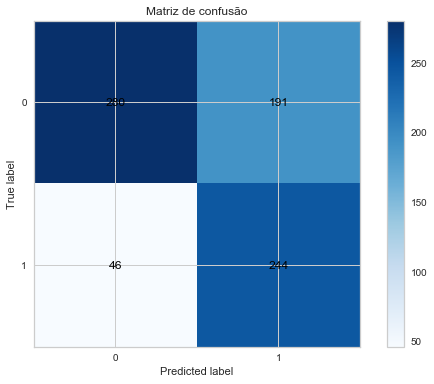

In [33]:
matriz_confusao(test_Y, predictions_svm)

In [72]:
metrica_geral(test_Y, predictions_svm)


              precision    recall  f1-score   support

           0       0.86      0.59      0.70       471
           1       0.56      0.84      0.67       290

    accuracy                           0.69       761
   macro avg       0.71      0.72      0.69       761
weighted avg       0.75      0.69      0.69       761



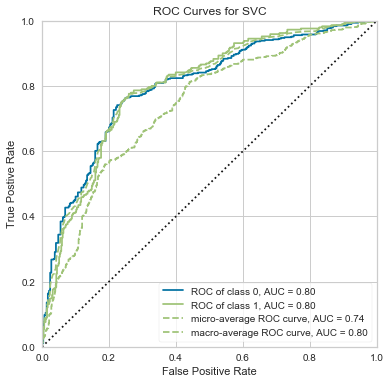

In [34]:
curva_ROC(pip_SVM_tfidf,test_X,test_Y)

#### SVM (RBF) com TF-IDF e unigram:

In [35]:
pip_SVM_tfidf_li.fit(train_X, train_Y)
predictions_svm2 = pip_SVM_tfidf_li.predict(test_X)

acuracia = accuracy_score(predictions_svm2, test_Y)
print(f"Acurácia da SVM: {acuracia*100:.3f}%")

Acurácia da SVM: 71.616%


In [36]:
f1_score(test_Y, predictions_svm2)

0.4757281553398059

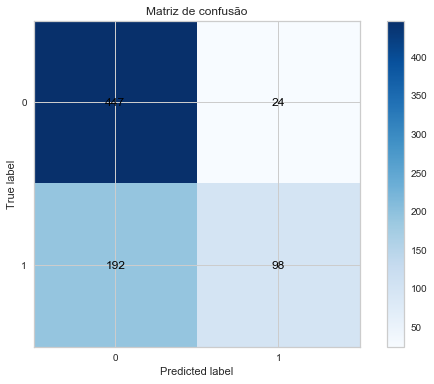

In [75]:
matriz_confusao(test_Y, predictions_svm2)

In [76]:
metrica_geral(test_Y, predictions_svm2)


              precision    recall  f1-score   support

           0       0.70      0.95      0.81       471
           1       0.80      0.34      0.48       290

    accuracy                           0.72       761
   macro avg       0.75      0.64      0.64       761
weighted avg       0.74      0.72      0.68       761



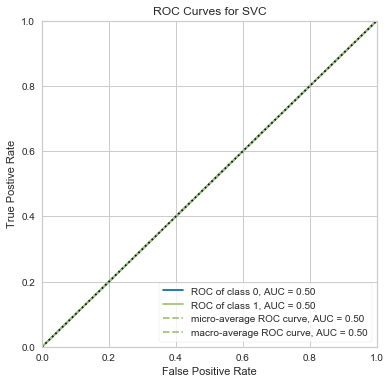

In [36]:
curva_ROC(pip_SVM_tfidf_li,test_X,test_Y)

#### SVM com TF-IDF e bigram:

In [37]:
pip_SVM_tfidf_bi.fit(train_X, train_Y)
predictions_svm_bigram = pip_SVM_tfidf_bi.predict(test_X)
acuracia = accuracy_score(predictions_svm_bigram, test_Y)
print(f"Acurácia da SVM com bigram: {acuracia*100:.3f}%")

Acurácia da SVM com bigram: 64.783%


In [39]:
f1_score(test_Y, predictions_svm_bigram)

0.6699507389162561

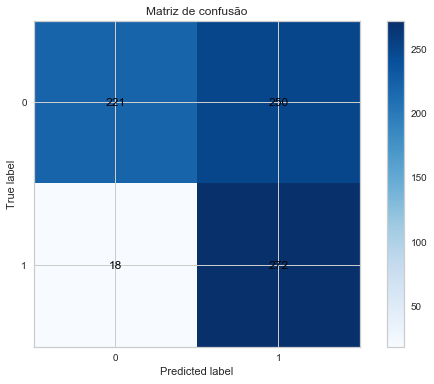

In [40]:
matriz_confusao(test_Y, predictions_svm_bigram)

In [64]:
metrica_geral(test_Y, predictions_svm_bigram)


              precision    recall  f1-score   support

           0       0.92      0.47      0.62       471
           1       0.52      0.94      0.67       290

    accuracy                           0.65       761
   macro avg       0.72      0.70      0.65       761
weighted avg       0.77      0.65      0.64       761



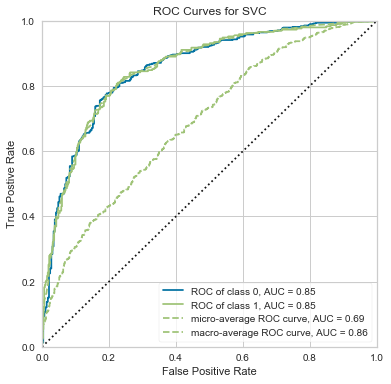

In [38]:
curva_ROC(pip_SVM_tfidf_bi,test_X,test_Y)

#### SVM (RBF) com TF-IDF e bigram:


In [39]:
#svm_bigram2 = SVC(C=1.0, kernel='rbf', degree=3, gamma='auto',probability=True)
pip_SVM_tfidf_bi_li.fit(train_X, train_Y)
predictions_svm_bigram2 = pip_SVM_tfidf_bi_li.predict(test_X)

acuracia = accuracy_score(predictions_svm_bigram2, test_Y)
print(f"Acurácia da SVM(rbf) com bigram: {acuracia*100:.3f}%")

Acurácia da SVM(rbf) com bigram: 71.222%


In [43]:
f1_score(test_Y, predictions_svm_bigram2)

0.4455696202531645

In [84]:
metrica_geral(test_Y, predictions_svm_bigram2)


              precision    recall  f1-score   support

           0       0.69      0.96      0.81       471
           1       0.84      0.30      0.45       290

    accuracy                           0.71       761
   macro avg       0.77      0.63      0.63       761
weighted avg       0.75      0.71      0.67       761



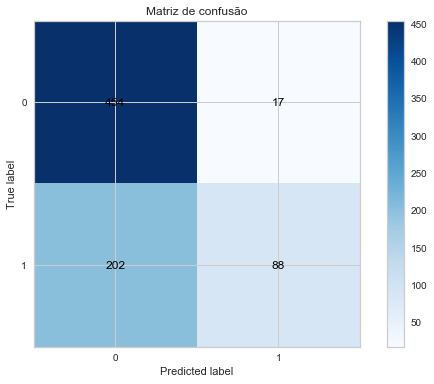

In [44]:
matriz_confusao(test_Y, predictions_svm_bigram2)

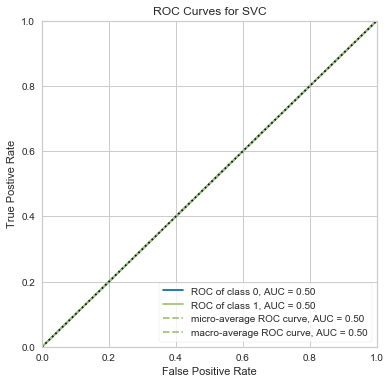

In [40]:
curva_ROC(pip_SVM_tfidf_bi_li,test_X,test_Y)

#### SVM com Bag of words e unigram:

In [41]:
pip_SVM_bag.fit(train_X, train_Y)
predictions_svm_bag = pip_SVM_bag.predict(test_X)

acuracia = accuracy_score(predictions_svm_bag, test_Y)
print(f"Acurácia da SVM: {acuracia*100:.3f}%")

Acurácia da SVM: 75.033%


In [46]:
f1_score(test_Y, predictions_svm_bag)

0.6915584415584416

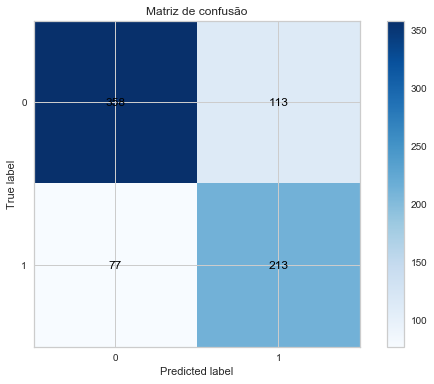

In [87]:
matriz_confusao(test_Y, predictions_svm_bag)

In [88]:
metrica_geral(test_Y, predictions_svm_bag)



              precision    recall  f1-score   support

           0       0.82      0.76      0.79       471
           1       0.65      0.73      0.69       290

    accuracy                           0.75       761
   macro avg       0.74      0.75      0.74       761
weighted avg       0.76      0.75      0.75       761



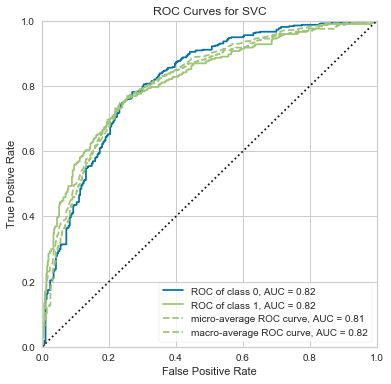

In [42]:
curva_ROC(pip_SVM_bag,test_X,test_Y)

#### SVM (RBF) com Bag of words e unigram:


In [43]:
pip_SVM_bag_li.fit(train_X,train_Y)
predictions_svm_bag2 = pip_SVM_bag_li.predict(test_X)

In [48]:
acuracia = accuracy_score(predictions_svm_bag2, test_Y)
print(f"Acurácia da SVM: {acuracia*100:.3f}%")

Acurácia da SVM: 80.420%


In [49]:
f1_score(test_Y, predictions_svm_bag2)

0.6989898989898989

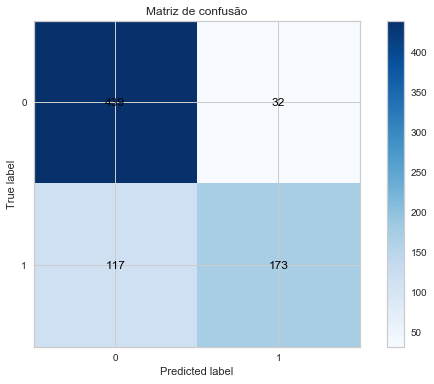

In [92]:
matriz_confusao(test_Y, predictions_svm_bag2)

In [93]:
metrica_geral(test_Y, predictions_svm_bag2)


              precision    recall  f1-score   support

           0       0.79      0.93      0.85       471
           1       0.84      0.60      0.70       290

    accuracy                           0.80       761
   macro avg       0.82      0.76      0.78       761
weighted avg       0.81      0.80      0.80       761



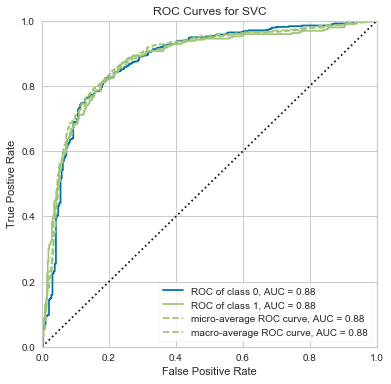

In [94]:
curva_ROC( pip_SVM_bag_li,test_X,test_Y)

####  SVM com bag of words e Bigram:

In [50]:
pip_SVM_bagbi.fit(train_X, train_Y)
predictions_svm_bag_bigram = pip_SVM_bagbi.predict(test_X)

acuracia = accuracy_score(predictions_svm_bag_bigram, test_Y)
print(f"Acurácia do SVM com bag of words e Bigram: {acuracia*100:.3f}%")

Acurácia do SVM com bag of words e Bigram: 78.581%


In [51]:
f1_score(test_Y, predictions_svm_bag_bigram)

0.7241962774957699

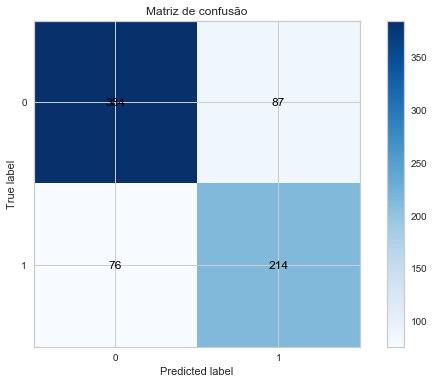

In [96]:
matriz_confusao(test_Y, predictions_svm_bag_bigram)

In [97]:
metrica_geral(test_Y, predictions_svm_bag_bigram)



              precision    recall  f1-score   support

           0       0.83      0.82      0.82       471
           1       0.71      0.74      0.72       290

    accuracy                           0.79       761
   macro avg       0.77      0.78      0.77       761
weighted avg       0.79      0.79      0.79       761



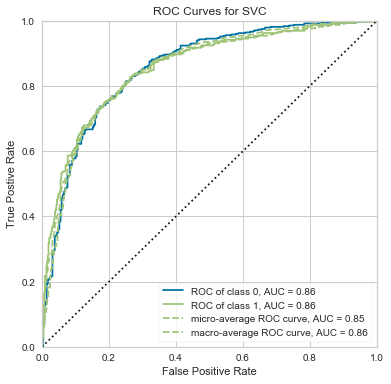

In [98]:
curva_ROC(pip_SVM_bagbi,test_X,test_Y)

####  SVM (RBF) com bag of words e Bigram:

In [52]:
pip_SVM_bagbi_li.fit(train_X, train_Y)
predictions_svm_bag_bigram2 = pip_SVM_bagbi_li.predict(test_X)

acuracia = accuracy_score(predictions_svm_bag_bigram2, test_Y)
print(f"Acurácia do SVM com bag of words e Bigram: {acuracia*100:.3f}%")

Acurácia do SVM com bag of words e Bigram: 67.280%


In [53]:
f1_score(test_Y, predictions_svm_bag_bigram2)

0.27826086956521734

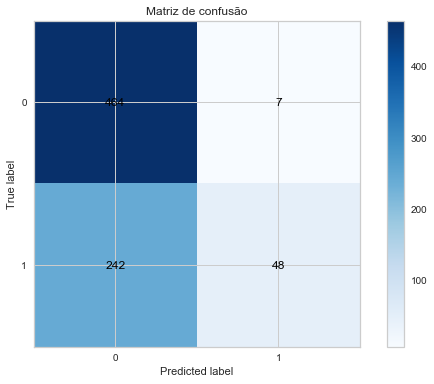

In [100]:
matriz_confusao(test_Y, predictions_svm_bag_bigram2)

In [101]:
metrica_geral(test_Y, predictions_svm_bag_bigram2)



              precision    recall  f1-score   support

           0       0.66      0.99      0.79       471
           1       0.87      0.17      0.28       290

    accuracy                           0.67       761
   macro avg       0.76      0.58      0.53       761
weighted avg       0.74      0.67      0.59       761



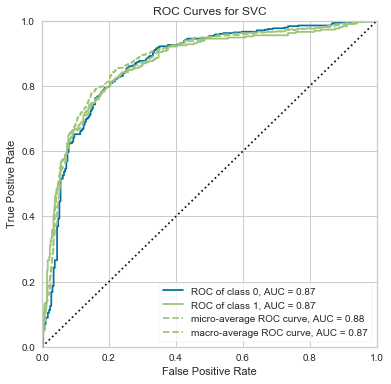

In [102]:
curva_ROC(pip_SVM_bagbi_li,test_X,test_Y)

## Naive Bayes

#### Multinomial Naive Bayes

#### MultinomialNB TF-IDF e unigram:

In [44]:
#multinb_tf = MultinomialNB(alpha=1.0, fit_prior=True, class_prior=None)
pip_multiNB_tfidf.fit(train_X, train_Y)
multinb_tf_prediction = pip_multiNB_tfidf.predict(test_X)

multinb_tf_acuracia = accuracy_score(multinb_tf_prediction, test_Y)
print(f"Acurácia do Multinomial Naive Bayes TF-IDF Unigram: {multinb_tf_acuracia*100:.3f}%")

Acurácia do Multinomial Naive Bayes TF-IDF Unigram: 39.816%


In [56]:
f1_score(test_Y, multinb_tf_prediction)

0.558766859344894

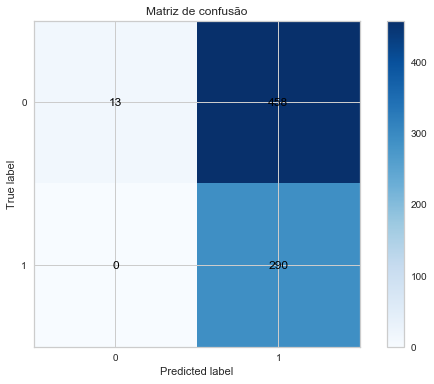

In [104]:
matriz_confusao(test_Y, multinb_tf_prediction)

In [65]:
metrica_geral(test_Y, multinb_tf_prediction)


              precision    recall  f1-score   support

           0       1.00      0.03      0.05       471
           1       0.39      1.00      0.56       290

    accuracy                           0.40       761
   macro avg       0.69      0.51      0.31       761
weighted avg       0.77      0.40      0.25       761



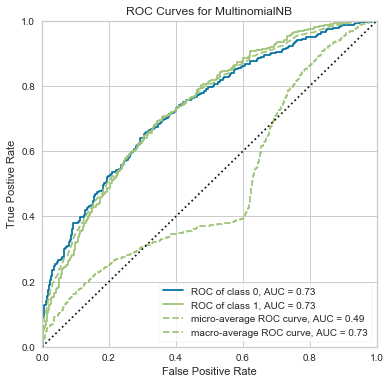

In [45]:
curva_ROC(pip_multiNB_tfidf,test_X,test_Y)

#### MultinomialNB TF-IDF Bigram

In [46]:
#multinb_tfbi = MultinomialNB(alpha=1.0, fit_prior=True, class_prior=None)
pip_multiNB_tfidf_bi.fit(train_X, train_Y)
multinb_tfbi_prediction = pip_multiNB_tfidf_bi.predict(test_X)

multinb_tfbi_acuracia = accuracy_score(multinb_tfbi_prediction, test_Y)
print(f"Acurácia do Multinomial Naive Bayes TF-IDF Bigram: {multinb_tfbi_acuracia*100:.3f}%")

Acurácia do Multinomial Naive Bayes TF-IDF Bigram: 38.108%


In [59]:
f1_score(test_Y, multinb_tfbi_prediction)

0.5518553758325404

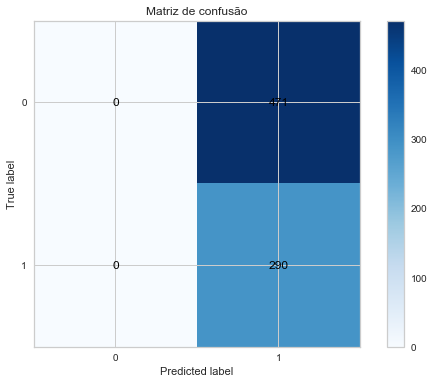

In [108]:
matriz_confusao(test_Y, multinb_tfbi_prediction)

In [66]:
metrica_geral(test_Y, multinb_tfbi_prediction)


              precision    recall  f1-score   support

           0       0.00      0.00      0.00       471
           1       0.38      1.00      0.55       290

    accuracy                           0.38       761
   macro avg       0.19      0.50      0.28       761
weighted avg       0.15      0.38      0.21       761



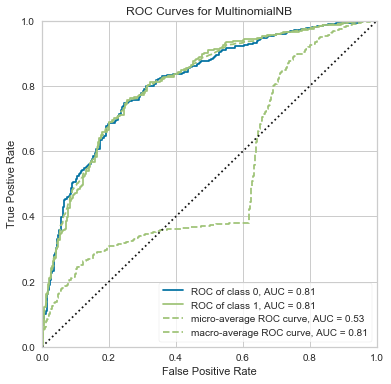

In [47]:
curva_ROC(pip_multiNB_tfidf_bi,test_X,test_Y)

#### MultinomialNB Bag of Words e unigram

In [48]:
#multinb_bag = MultinomialNB(alpha=1.0, fit_prior=True, class_prior=None)
pip_multiNB_bag.fit(train_X, train_Y)
multinb_bag_prediction = pip_multiNB_bag.predict(test_X)

multinb_bag_acuracia = accuracy_score(multinb_bag_prediction, test_Y)
print(f"Acurácia do Multinomial Naive Bayes Bag of Words Unigram: {multinb_bag_acuracia*100:.3f}%")

Acurácia do Multinomial Naive Bayes Bag of Words Unigram: 49.540%


In [61]:
f1_score(test_Y, multinb_bag_prediction)

0.5914893617021277

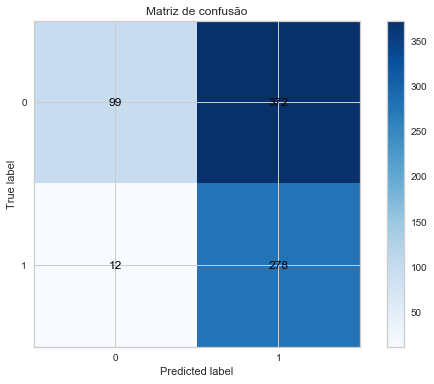

In [112]:
matriz_confusao(test_Y, multinb_bag_prediction)

In [113]:
metrica_geral(test_Y, multinb_bag_prediction)


              precision    recall  f1-score   support

           0       0.89      0.21      0.34       471
           1       0.43      0.96      0.59       290

    accuracy                           0.50       761
   macro avg       0.66      0.58      0.47       761
weighted avg       0.71      0.50      0.44       761



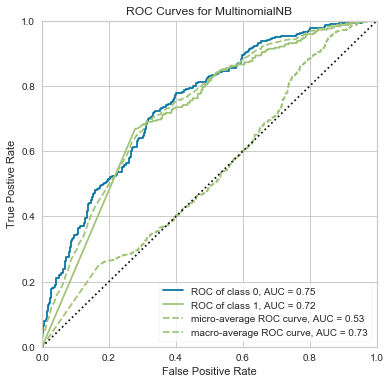

In [49]:
curva_ROC(pip_multiNB_bag,test_X,test_Y)

#### MultinomialNB Bag of Words Bigram

In [50]:
#multinb_bagbi = MultinomialNB(alpha=1.0, fit_prior=True, class_prior=None)

pip_multiNB_bagbi.fit(train_X, train_Y)
multinb_bagbi_prediction = pip_multiNB_bagbi.predict(test_X)

multinb_bagbi_acuracia = accuracy_score(multinb_bagbi_prediction, test_Y)
print(f"Acurácia do Multinomial Naive Bayes Bag of Words Bigram: {multinb_bagbi_acuracia*100:.3f}%")

Acurácia do Multinomial Naive Bayes Bag of Words Bigram: 38.239%


In [63]:
f1_score(test_Y, multinb_bagbi_prediction)

0.5523809523809524

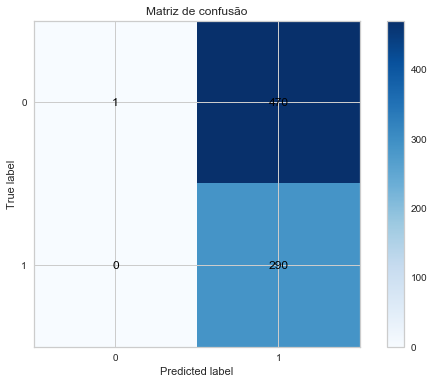

In [116]:
matriz_confusao(test_Y, multinb_bagbi_prediction)

In [67]:
metrica_geral(test_Y, multinb_bagbi_prediction)


              precision    recall  f1-score   support

           0       1.00      0.00      0.00       471
           1       0.38      1.00      0.55       290

    accuracy                           0.38       761
   macro avg       0.69      0.50      0.28       761
weighted avg       0.76      0.38      0.21       761



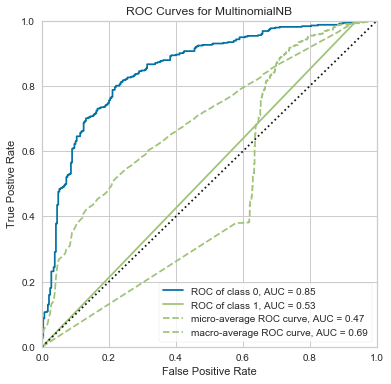

In [51]:
curva_ROC(pip_multiNB_bagbi,test_X,test_Y)

##### Gaussian Naive Bayes

In [52]:
vectorizer = CountVectorizer()

train_X_bagwords = vectorizer.fit_transform(df2['tratamento_1']).toarray()

test_X_bagwords = vectorizer.transform(df_validacao['tratamento_1']).toarray()

vectorizer_bigram = CountVectorizer(ngram_range=(1, 2))

train_X_bagwords_bigram = vectorizer_bigram.fit_transform(df2['tratamento_1']).toarray()

test_X_bagwords_bigram = vectorizer_bigram.transform(df_validacao['tratamento_1']).toarray()


tfidf_vector = TfidfVectorizer()

train_X_tfidf = tfidf_vector.fit_transform(df2['tratamento_1']).toarray()

test_X_tfidf = tfidf_vector.transform(df_validacao['tratamento_1']).toarray()

tfidf_vector_bigram = TfidfVectorizer(ngram_range=(1,2))

train_X_tfidf_bigram = tfidf_vector_bigram.fit_transform(df2['tratamento_1']).toarray()
test_X_tfidf_bigram = tfidf_vector_bigram.transform(df_validacao['tratamento_1']).toarray()



In [53]:
test_X_bagwords.shape

(761, 32945)

In [54]:
test_X_bagwords_bigram.shape

(761, 757482)

In [55]:
test_X_tfidf.shape

(761, 32945)

In [56]:
test_X_tfidf_bigram.shape

(761, 757482)

In [57]:
gaussianb_tf = GaussianNB()
gaussianb_tfbi = GaussianNB()
gaussianb_bag = GaussianNB()
gaussianb_bagbi = GaussianNB()

#### Cross Validate Gaussian Naive Bayes

In [29]:
cross_validate(gaussianb_tf, train_X_tfidf, df2.CLASS, return_train_score=False,
               scoring=['accuracy',
                        'f1',
                        'precision',
                        'recall',
                        'roc_auc'])

{'fit_time': array([7.28656173, 5.83499193, 4.41418004, 3.89856005, 6.2765677 ]),
 'score_time': array([2.2490201 , 1.65274692, 1.54298878, 1.53450179, 3.18916726]),
 'test_accuracy': array([0.67344498, 0.71172249, 0.67583732, 0.69019139, 0.63995215]),
 'test_f1': array([0.74977085, 0.77156398, 0.74553991, 0.76084949, 0.73244444]),
 'test_precision': array([0.6077266 , 0.6389325 , 0.61360124, 0.61954887, 0.58274399]),
 'test_recall': array([0.9784689 , 0.97368421, 0.94976077, 0.98564593, 0.98564593]),
 'test_roc_auc': array([0.67344498, 0.71172249, 0.67583732, 0.69019139, 0.63995215])}

In [ ]:
cross_validate(gaussianb_tfbi, train_X_tfidf_bigram, df2.CLASS, return_train_score=False,
               scoring=['accuracy',
                        'f1',
                        'precision',
                        'recall',
                        'roc_auc'])

In [ ]:
cross_validate(gaussianb_bag, train_X_bagwords, df2.CLASS, return_train_score=False,
               scoring=['accuracy',
                        'f1',
                        'precision',
                        'recall',
                        'roc_auc'])

In [ ]:
cross_validate(gaussianb_bagbi, train_X_bagwords_bigram, df2.CLASS, return_train_score=False,
               scoring=['accuracy',
                        'f1',
                        'precision',
                        'recall',
                        'roc_auc'])

#### GaussianNB TF-IDF

In [42]:

gaussianb_tf.fit(train_X_tfidf, df2.CLASS)
gaussianb_tf_prediction = gaussianb_tf.predict(test_X_tfidf)

acuracia = accuracy_score(gaussianb_tf_prediction, df_validacao.Fake)
print(f"Acurácia do Gaussian Naive Bayes TF-IDF Unigram: {acuracia*100:.3f}%")

Acurácia do Gaussian Naive Bayes TF-IDF Unigram: 45.729%


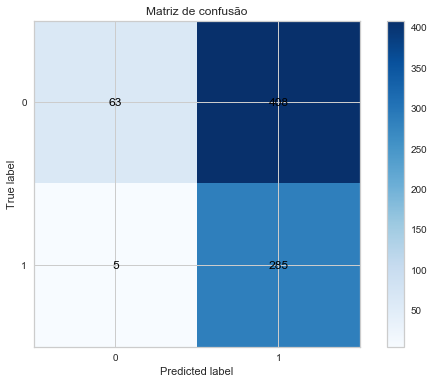

In [43]:
matriz_confusao(test_Y, gaussianb_tf_prediction)

In [44]:
metrica_geral(test_Y, gaussianb_tf_prediction)


              precision    recall  f1-score   support

           0       0.93      0.13      0.23       471
           1       0.41      0.98      0.58       290

    accuracy                           0.46       761
   macro avg       0.67      0.56      0.41       761
weighted avg       0.73      0.46      0.37       761



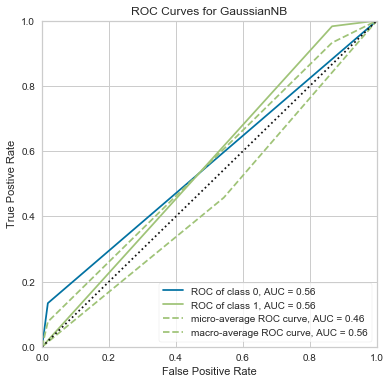

In [45]:
curva_ROC(gaussianb_tf,test_X_tfidf,test_Y)

#### GaussianNB TF-IDF Bigram

In [ ]:
gaussianb_tfbi.fit(train_X_tfidf_bigram, df2.CLASS)
gaussianb_tfbi_prediction = gaussianb_tfbi.predict(test_X_tfidf_bigram)

acuracia = accuracy_score(gaussianb_tfbi_prediction, test_Y)
print(f"Acurácia do Gaussian Naive Bayes TF-IDF Bigram: {acuracia*100:.3f}%")

In [ ]:
matriz_confusao(test_Y, gaussianb_tfbi_prediction)

In [ ]:
metrica_geral(test_Y, gaussianb_tfbi_prediction)


In [ ]:
curva_ROC(gaussianb_tfbi,test_X_tfidf_bigram,test_Y)

#### GaussianNB Bag of Words 

In [75]:
gaussianb_bag.fit(train_X_bagwords, df2.CLASS)
gaussianb_bag_prediction = gaussianb_bag.predict(test_X_bagwords)

acuracia = accuracy_score(gaussianb_bag_prediction, test_Y)
print(f"Acurácia do Gaussian Naive Bayes TF-IDF Unigram: {acuracia*100:.3f}%")

Acurácia do Gaussian Naive Bayes TF-IDF Unigram: 45.861%


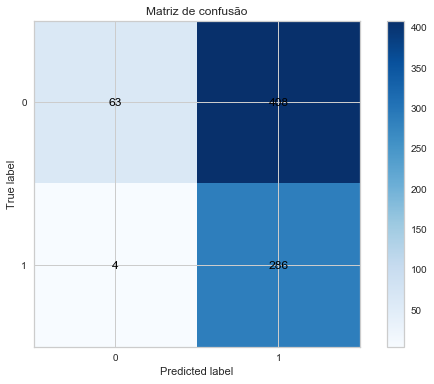

In [76]:
matriz_confusao(test_Y, gaussianb_bag_prediction)

In [77]:
metrica_geral(test_Y, gaussianb_bag_prediction)


              precision    recall  f1-score   support

           0       0.94      0.13      0.23       471
           1       0.41      0.99      0.58       290

    accuracy                           0.46       761
   macro avg       0.68      0.56      0.41       761
weighted avg       0.74      0.46      0.37       761



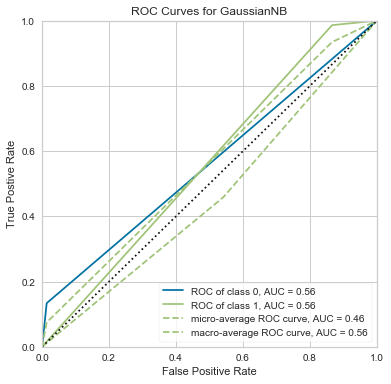

In [78]:
curva_ROC(gaussianb_bag,test_X_bagwords,test_Y)

#### GaussianNB Bag of Words Bigram

In [ ]:
gaussianb_bagbi.fit(train_X_bagwords_bigram, df2.CLASS)
gaussianb_bagbi_prediction = gaussianb_bagbi.predict(test_X_bagwords_bigram)

acuracia = accuracy_score(gaussianb_bagbi_prediction, df_validacao.Fake)
print(f"Acurácia do Gaussian Naive Bayes Bag of words Bigram: {acuracia*100:.3f}%")

In [ ]:
matriz_confusao(test_Y, gaussianb_bagbi_prediction)

In [ ]:
metrica_geral(test_Y, gaussianb_bagbi_prediction)


In [ ]:
curva_ROC(gaussianb_bagbi,test_X_bagwords_bigram,test_Y)

## Visualização da distribuição de notícias fakew news para não fake

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


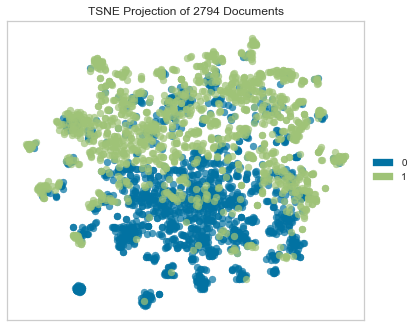

In [144]:
from yellowbrick.text import TSNEVisualizer
tfidf  = TfidfVectorizer()
docs   = tfidf.fit_transform(df.tratamento_1)
labels = df.Fake

tsne = TSNEVisualizer()
tsne.fit(docs, labels)
tsne.poof()

## GridSearch

In [ ]:
anova_svm_bag = Pipeline([('vectorizer', CountVectorizer()), ('classifier', SVC())])
anova_svm_tfidf = Pipeline([('vectorizer',TfidfVectorizer()), ('classifier', SVC())])





In [ ]:
def hiperparameter(trainX,trainY,anova_svm):
    tuned_parameters = [{'vectorizer__ngram_range': [(1,1),(1,2),(1,3)],
                          'classifier__C': [0.001, 0.01, 0.1, 1, 5, 10, 100]}]
    clf = GridSearchCV(anova_svm,tuned_parameters, cv=5, scoring='precision',verbose = 1)
    clf.fit(trainX, trainY)
    return clf


In [ ]:
texts = train_X['tratamento_1'].tolist()

In [ ]:
len(train_Y)

In [ ]:
clf = hiperparameter(texts, train_Y,anova_svm_bag)
clf.cv_results_


In [ ]:
clf.best_params_


In [ ]:
clf2 = hiperparameter(texts, train_Y,anova_svm_tfidf)
clf2.cv_results_

In [ ]:
clf2.best_params_


In [ ]:
svm_bag = Pipeline([('vectorizer', CountVectorizer()), ('classifier', SVC(C=1, kernel='linear',probability=True))])
svm_tf = Pipeline([('vectorizer', TfidfVectorizer()), ('classifier', SVC(C=1, kernel='linear',probability=True))])


In [ ]:
#texts_test = test_X['tratamento_1'].tolist()
texts_test = test_X[['tratamento_1','qt_palavras']].tolist()
svm_bag.fit(texts, train_Y)
y_pred_bag = svm_bag.predict(texts_test)
svm_tf.fit(texts, train_Y)
y_pred_tf = svm_tf.predict(texts_test)

#### Métrica com bag of words

In [ ]:
metrica_geral(test_Y,y_pred_bag)


#### Métrica com TF-IDF

In [ ]:
metrica_geral(test_Y,y_pred_tf)


In [ ]:
curva_ROC(svm_tf,texts,train_Y)

In [1]:
import pickle


In [ ]:
output = open('athena','wb')
#para armazenar/serializar nosso modelo
pickle.dump(pip_SVM_bagbi_li,output)
output.close()

In [252]:
df2[df2['CLASS']==0].shape

(2090, 31)

In [253]:
df2[df2['CLASS']==1].shape

(910, 31)

In [255]:
df2.to_csv('df_teste.csv')

In [254]:
df2.shape

(3000, 31)